In [1]:
import pickle

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import disruption_py
from disruption_py.shots import Shot, D3DShot
from disruption_py.database import *
try:
    import importlib.resources as importlib_resources
except ImportError:
    # Try backported to PY<37 `importlib_resources`.
    import importlib_resources

In [2]:
with open("/fusion/projects/disruption_warning/disruption-warning-db-workflow/data/namespace.pkl", "rb") as f:
    namespace = pickle.load(f, encoding='latin1')
with open("/fusion/projects/disruption_warning/disruption-warning-db-workflow/data/TEST.pkl", "rb") as f:
    test= pickle.load(f, encoding='latin1')
with open("/fusion/projects/disruption_warning/disruption-warning-db-workflow/data/TRAIN.pkl", "rb") as f:
    train = pickle.load(f, encoding='latin1')
with open("/fusion/projects/disruption_warning/disruption-warning-db-workflow/data/d3d_manual_events.pkl", 'rb') as f:
    d3d_manual_events = pickle.load(f, encoding='latin1')
with importlib_resources.path(disruption_py.data, "paper_shotlist.txt") as p:
    paper_shotlist = pd.read_csv(str(p), header=None, names=['shot'])

In [4]:
d3d = create_d3d_handler()

# Matlab vs Python Comparison

In [ ]:
comparison_cols = ['aminor','n_e','ip','delta','li','Wmhd','kappa','squareness']
comparisons = {'medians':{},'means':{}}
for col in comparison_cols:
    comparisons['medians'][col] = []
    comparisons['means'][col] = []
for shot_id in list(paper_shotlist['shot'])[:50]:
    local_shot = D3DShot(shot_id, d3d.get_efit_tree(
            shot_id), disruption_time=d3d.get_disruption_time(shot_id),populate='test_mode')
    true_shot = d3d.get_shot(shot_id)
    for col in comparison_cols:
        try:
            comparison = np.abs(local_shot.data[col] - true_shot.data[col])/true_shot.data[col]
        except Exception as e:
            print(local_shot.data[col])
            print(true_shot.data[col])
            print(e)
        comparisons['medians'][col].append(np.median(comparison))
        comparisons['means'][col].append(np.mean(comparison))

In [12]:
print(comparisons['medians'])

{'aminor': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'n_e': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'ip': [nan, 4.129535790439455e-15, 7.010378668145905e-15, 7.082182271743313e-15, nan, nan, 9.518824948604323e-16, 4.3256944134361516e-16, 5.053938785991852e-15, 5.0705433602965746e-15, 6.891394472382764e-15, nan, 4.168651123965453e-15, 3.475773101020492e-15, 4.426304704937881e-15, 3.316746011356268e-15, 4.25059519373145e-15, 3.223182034216972e-15, 3.587874162851781e-15, 5.0951062927491e-15, 3.198660565139318e-15, 2.831466531088509e-15, 5.001470517067332e-15, 3.9176686215601

In [ ]:
# Plot average median and mean over all shots for each column
fig, ax = plt.subplots(1,1,figsize=(10,5))
for col in comparison_cols:
    ax.bar(list(comparison_cols.keys()), [np.mean(comparisons['medians'][col]) for col in comparison_cols], label='Median')
    ax.set_title('Median Comparison')
    ax.set_xlabel('Column')
    ax.set_ylabel('Median')
    ax.legend()
fig.savefig("test.png")
print("Test")

# Profiling 

/home/turnerh/disruptions/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


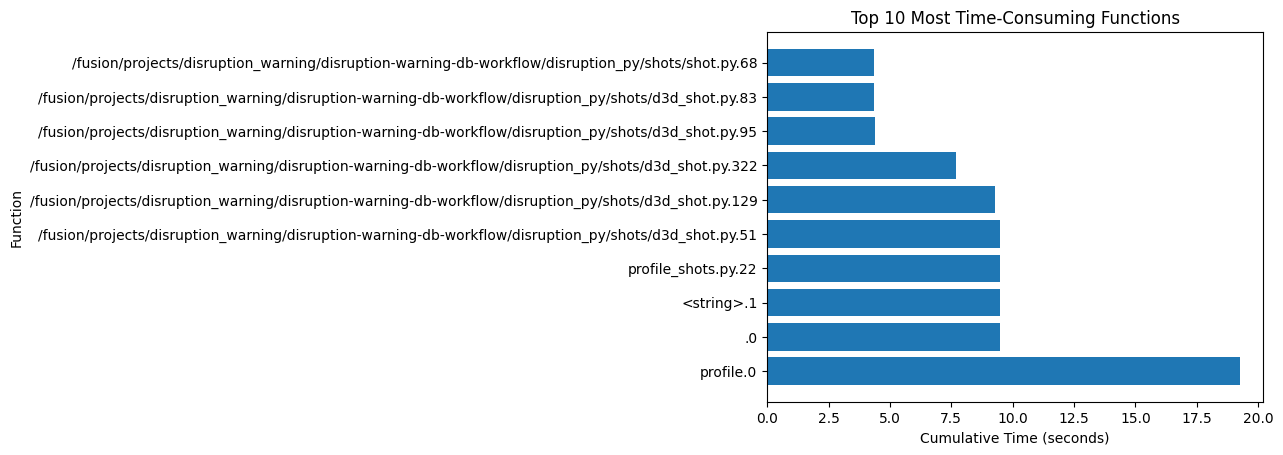

In [3]:
import pstats 
stats = pstats.Stats(r"/fusion/projects/disruption_warning/disruption-warning-db-workflow/scripts/shot_175552_EFIT01_profileX5")
stats.sort_stats(pstats.SortKey.CUMULATIVE)
top_n = 10
top_stats = stats.fcn_list[:top_n]

# Extract function names and cumulative times
func_names = []
func_cumtimes = []
for func in top_stats:
    func_name = f"{func[0]}.{func[1]}"
    func_cumtime = stats.stats[func][3]
    func_names.append(func_name)
    func_cumtimes.append(func_cumtime)

# Create a bar plot
plt.barh(func_names, func_cumtimes)
plt.xlabel("Cumulative Time (seconds)")
plt.ylabel("Function")
plt.title("Top 10 Most Time-Consuming Functions")
plt.tight_layout()
plt.savefig("profiling.png")


In [ ]:
step = .995 
index = np.arange(0,101)
arr_1 = np.arange(0, 100, step)
arr_2 = np.array([i*step for i in range(101)])
plt.plot(index, arr_1, label='step = .995')
plt.plot(index, arr_2, label='step = .995')

In [ ]:
from disruption_py.ml import *

In [ ]:

    data = pd.read_csv(args.data_path)
    model = load_model(args.model_path)
    data = predict(model, data)
    data.to_csv(args.output_dir + f"eval_data_{args.unique_id}.csv")
    results = eval_shots(data)
    print(results)
    conf_mat = np.array([[results['TN'], results['FP']],
                         [results['FN'], results['TP']]])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat, display_labels=model.classes_)
    disp.plot()
    save_open_plots(args.output_dir + f"eval_shots_{args.unique_id}.pdf")
    with open(args.output_dir + f"eval_{args.unique_id}.json", "w") as f:
        json.dump(vars(args), f)
    if args.visualize:
        if results['FP'] + results['TP'] + results['FN'] + results['TN'] < 20:
            plt.show()
        else:
            print("Displaying plots would open too many figures (>20). Plots have been saved but will not be displayed")
    print(f"Unique ID for this run: {args.unique_id}")


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_path', type=str,
                        default='/fusion/projects/disruption_warning/papers/SORI2020/forest_245_20_dan.pkl')
    parser.add_argument('--output_dir', type=str, default='./output/')
    parser.add_argument('data_path', type=str)
    parser.add_argument('--visualize', type=bool, default=True)
    parser.add_argument('--unique_id', type=str,
                        help='Unique identifier for the dataset. Used to name the output files.', default=generate_id())
    args = parser.parse_args()
    main(args)